### Figure 7: Stochasticity 

In [2]:
import numpy as np
from esda.moran import Moran,Moran_Local
from libpysal.weights import lat2W
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import properscoring as ps
import warnings
from scipy import stats
# from utils.evaluation import plot_histogram,calc_peak,calc_mean
from sklearn.metrics import mean_squared_error
from math import sqrt
import xesmf as xe
warnings.filterwarnings("ignore")
sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))

# https://journals.ametsoc.org/view/journals/atsc/72/6/jas-d-14-0250.1.xml
# https://www.sciencedirect.com/science/article/pii/S0021999107000812

/user/work/al18709/.conda/envs/aquatic/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
model = ''
# set mode
mode = 'validation'

# load datasets
real = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_real-opt.npy' % (model,mode))[0][:,:,:,0]
pred = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_pred-opt.npy' % (model,mode))[0][:,:,:,0]

pred_cnn = np.load('/user/home/al18709/work/cnn/unet_valid.npy')
pred_dsrnngan = np.load('/user/home/al18709/work/dsrnngan_predictions/validation_pred-opt.npy')[0][:,:,:,0]
pred_vaegan = np.load('/user/home/al18709/work/vaegan/predictions/validation_pred.npy')[0][:,:,:,0]

pred_ensemble_vaegan = np.load('/user/home/al18709/work/vaegan/predictions/validation_pred.npy')[0]
pred_ensemble_gan = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_pred-opt.npy' % (model,mode))[0]
inputs = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_input-opt.npy' % (model,mode))[0][:,:,:,0]

# regrid inputs
grid_in = {"lon": np.linspace(0, 100, 10), "lat": np.linspace(0, 100, 10)}
grid_out = {"lon": np.linspace(0, 100, 100), "lat": np.linspace(0, 100, 100)}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
inputs_hr = regridder(inputs)

print(inputs_hr.shape)

(16253, 100, 100)


In [22]:
i=0
j=0
_,_,_,n = pred_ensemble_gan.shape
var = np.var(pred_ensemble_gan[0,:,:,:],axis=2)
correction_var = n / (n - 1)
var = var * correction_var

print(pred_ensemble_gan.shape)
ens_mean = np.mean(pred_ensemble_gan[0,:,:,:],axis=2)
print(ens_mean.shape)
mse = np.square(ens_mean - real[0,:,:])
correction_mse = n / (n + 1)
mse = mse * correction_mse

var_flat = var.flatten()
mse_flat = mse.flatten()

# put into 20 bins of 5% percentiles of the spread
mean_vars = []
mean_mses = []
for i,p in enumerate(range(5,100,5)):

	# find the indexes of the element below 25th and 50th percentile
	idx_under_p1 = np.argwhere(var_flat <= np.percentile(var_flat, p)).ravel()
	idx_under_p2 = np.argwhere(var_flat <= np.percentile(var_flat, range(5,105,5)[i+1])).ravel()

	# find the number of the elements in between 25th and 50th percentile
	diff_num = len(idx_under_p1) - len(idx_under_p2)

	# find the sum difference
	diff_sum_var = np.sum(np.take(var_flat, idx_under_p2)) - np.sum(np.take(var_flat, idx_under_p1))
	diff_sum_mse = np.sum(np.take(mse_flat, idx_under_p2)) - np.sum(np.take(mse_flat, idx_under_p1))

	# get the mean
	mean_mse = diff_sum_mse / diff_num
	mean_var = diff_sum_var / diff_num

	mean_vars.append(mean_var)
	mean_mses.append(mean_mse)

print(mean_vars)
print(mean_mses)

rmse = np.sqrt(mean_mses)
rmss = np.sqrt(mean_vars)

print(rmse)
print(rmss)

# TODO: why is this negative!?

(16253, 100, 100, 10)
(100, 100)
[-0.00039841829123692346, -0.0008014235922333188, -0.0013594541974466167, -0.00209720761575702, -0.0031315571741011602, -0.004596954782767958, -0.00657422396139674, -0.009354818101574942, -0.013721688466462354, -0.02086052396489457, -0.03296776759814439, -0.05346785583965166, -0.08192016007219166, -0.13008703211456077, -0.22967846346334483, -0.4912664426952207, -1.2207419020836248, -3.3914684409808773, -21.28076322306723]
[-0.003623030500817242, -0.007800028635553391, -0.009589646428860604, -0.01793567906471967, -0.021005688616748935, -0.020742483772029266, -0.07214329294704816, -0.1197546070565105, -0.16204324087871402, -0.18993564253935732, -0.3116195574304955, -0.3715108731750189, -0.5677395808112804, -0.8645845669860684, -1.9439355346335883, -3.6982021227730693, -5.299398168723664, -8.141988173912997, -14.809448507380214]
[-0.003623030500817242, -0.007800028635553391, -0.009589646428860604, -0.01793567906471967, -0.021005688616748935, -0.02074248377

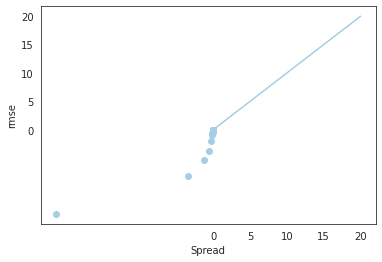

In [23]:
plt.scatter(rmss,rmse)
plt.xlabel('Spread')
plt.ylabel('rmse')
plt.xticks([0,5,10,15,20])
plt.yticks([0,5,10,15,20])
plt.plot([0,5,10,15,20],[0,5,10,15,20])
plt.show()